In [1]:
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.layers import Dense, Flatten, Conv2D, BatchNormalization
from tensorflow.keras import Model
import time
import sys
sys.path.append('cvae')
sys.path.append('/tf/code/preprocess/data_loader')
from data_loader import DataLoader
from cvae import CVAE, optimizer, log_normal_pdf, compute_loss, train_step

loader = DataLoader()
print(loader.length, loader.length_rois)

2023-05-25 23:52:32.904336: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Detectron2 not imported


2023-05-25 23:52:35.960387: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-25 23:52:35.978585: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-25 23:52:35.978768: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

3557 11003


s-bus-pci#L344-L355
2023-05-25 23:52:36.857151: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-25 23:52:36.857319: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-25 23:52:36.857460: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4497 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1660 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5


In [2]:
batch_size = 4
num_channels = 1
num_classes = 8
image_size = 224
latent_dim = 128

In [3]:
dataset = tf.data.Dataset.from_generator(loader.classification_generator(output_size=(image_size,image_size),
                                                                         classify_types=True,
                                                                         types_as="hot_encode"
                                                                        ),
                                         output_signature=(
                                             tf.TensorSpec(shape=(image_size,image_size,1), dtype=tf.float32, name="image"),
                                             tf.TensorSpec(shape=(num_classes), dtype=tf.float32, name="label")
                                         ),
                                        )



2023-05-25 23:52:37.021177: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


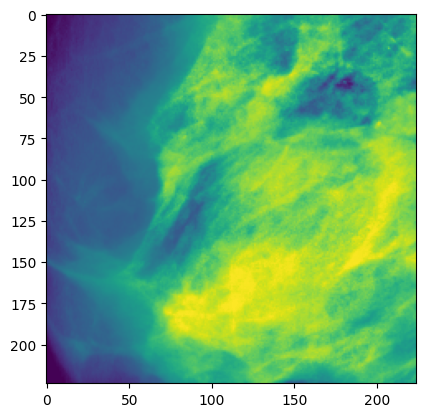

In [ ]:
plt.imshow(next(iter(dataset.take(1)))[0])

In [5]:
train_ds = dataset.batch(batch_size)

In [6]:
generator_in_channels = latent_dim + num_classes
discriminator_in_channels = num_channels + num_classes
print(generator_in_channels, discriminator_in_channels)

136 9


In [7]:
# Create the discriminator.
discriminator = tf.keras.Sequential(
    [
        tf.keras.layers.InputLayer((image_size, image_size, discriminator_in_channels)),
        tf.keras.layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.GlobalMaxPooling2D(),
        tf.keras.layers.Dense(1),
    ],
    name="discriminator",
)

# Create the generator.
generator = tf.keras.Sequential(
    [
        tf.keras.layers.InputLayer((generator_in_channels,)),
        # We want to generate 128 + num_classes coefficients to reshape into a
        # 7x7x(128 + num_classes) map.
        tf.keras.layers.Dense(7 * 7 * generator_in_channels),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.Reshape((7, 7, generator_in_channels)),
        tf.keras.layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.UpSampling2D(size=(8,8)),
        tf.keras.layers.Conv2D(1, (7, 7), padding="same", activation="sigmoid"),
    ],
    name="generator",
)

generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 6664)              912968    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 6664)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 136)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      278656    
 nspose)                                                         
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 128)      262272    
 ranspose)                                               

In [8]:
class ConditionalGAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.gen_loss_tracker = tf.keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = tf.keras.metrics.Mean(name="discriminator_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        # Unpack the data.
        real_images, one_hot_labels = data

        # Add dummy dimensions to the labels so that they can be concatenated with
        # the images. This is for the discriminator.
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = tf.repeat(
            image_one_hot_labels, repeats=[image_size * image_size]
        )
        image_one_hot_labels = tf.reshape(
            image_one_hot_labels, (-1, image_size, image_size, num_classes)
        )

        # Sample random points in the latent space and concatenate the labels.
        # This is for the generator.
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Decode the noise (guided by labels) to fake images.
        generated_images = self.generator(random_vector_labels)

        # Combine them with real images. Note that we are concatenating the labels
        # with these images here.
        fake_image_and_labels = tf.concat([generated_images, image_one_hot_labels], -1)
        real_image_and_labels = tf.concat([real_images, image_one_hot_labels], -1)
        combined_images = tf.concat(
            [fake_image_and_labels, real_image_and_labels], axis=0
        )

        # Assemble labels discriminating real from fake images.
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )

        # Train the discriminator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space.
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Assemble labels that say "all real images".
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_vector_labels)
            fake_image_and_labels = tf.concat([fake_images, image_one_hot_labels], -1)
            predictions = self.discriminator(fake_image_and_labels)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }

In [9]:
cond_gan = ConditionalGAN(
    discriminator=discriminator, generator=generator, latent_dim=latent_dim
)
cond_gan.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn=tf.keras.losses.BinaryCrossentropy(from_logits=True),
)

In [10]:
cond_gan.fit(train_ds, epochs=25)

Epoch 1/25


2023-05-25 23:52:37.456702: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-25 23:52:39.850625: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-05-25 23:52:41.465698: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.71GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-05-25 23:52:41.466520: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.71GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be

2751/2751 [==============================] - 476s 170ms/step - g_loss: 8.2088 - d_loss: 0.0205
Epoch 2/25
2751/2751 [==============================] - 469s 170ms/step - g_loss: 12.1430 - d_loss: 2.9681e-06
Epoch 3/25
2751/2751 [==============================] - 479s 174ms/step - g_loss: 14.1812 - d_loss: 4.1484e-07
Epoch 4/25
2751/2751 [==============================] - 461s 167ms/step - g_loss: 15.8019 - d_loss: 7.1820e-08
Epoch 5/25
2751/2751 [==============================] - 460s 167ms/step - g_loss: 17.2256 - d_loss: 1.6770e-08
Epoch 6/25
2751/2751 [==============================] - 466s 169ms/step - g_loss: 13.3640 - d_loss: 8.1320e-04
Epoch 7/25
2751/2751 [==============================] - 469s 171ms/step - g_loss: 15.2905 - d_loss: 1.2256e-07
Epoch 8/25
2751/2751 [==============================] - 472s 172ms/step - g_loss: 16.9397 - d_loss: 2.3463e-08
Epoch 9/25
2751/2751 [==============================] - 458s 167ms/step - g_loss: 17.9797 - d_loss: 8.0051e-09
Epoch 10/25
2751/

In [11]:
# We first extract the trained generator from our Conditiona GAN.
trained_gen = cond_gan.generator

trained_gen.save("trained_conditional_gan")

2023-05-26 03:06:37.469121: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,136]
	 [[{{node inputs}}]]
2023-05-26 03:06:37.490789: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,128]
	 [[{{node inputs}}]]
2023-05-26 03:06:37.503957: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,?]
	 [[{{node inputs}}]]
2023-0

INFO:tensorflow:Assets written to: trained_conditional_gan/assets


INFO:tensorflow:Assets written to: trained_conditional_gan/assets


1/1 [==============================] - 0s 14ms/step


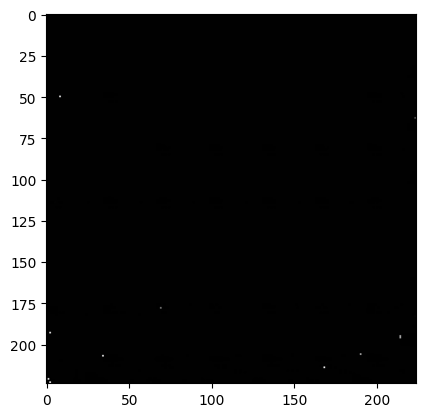

In [24]:
def generate_sample(label_ex):
    interpolation_noise = tf.random.normal(shape=(1, latent_dim))
    label = tf.keras.utils.to_categorical([label_ex], num_classes)
    label = tf.cast(label, tf.float32)
    noise_and_label = tf.concat([interpolation_noise, label], 1)
    fake = trained_gen.predict(noise_and_label)
    fake=fake*255
    fake=fake.astype(np.uint8)
    return fake*255

plt.imshow(generate_sample(0)[0], cmap="gray")